In [134]:
from dataclasses import field, dataclass
import itertools

import torch
import numpy as np
import matplotlib.pyplot as plt

import blackjack as bj

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%matplotlib inline
np.random.seed(0)

In [4]:
@dataclass
class State:
    hand_total: int
    dealer_total: int
    
    def __hash__(self) -> int:
        return hash((self.hand_total, self.dealer_total))

In [5]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 128, device=device),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 2, device=device),
        )

    def forward(self, x) -> torch.Tensor:
        return self.layers(x)

In [6]:
@dataclass
class RewardTracker:
    discount_factor: float = field(default=0.99)
    
    rewards: np.ndarray[_, _] = field(default_factory=lambda: np.zeros(shape=1, dtype=np.float64)) # type: ignore
    
    def __post_init__(self):
        self.rewards = np.array([])

    def set_rewards(self, episode_rewards: np.ndarray) -> None:
        self.rewards = episode_rewards
    
    def add_reward(self, reward: float) -> None:
        self.rewards = np.append(self.rewards, reward)
    
    @property  
    def mean_reward(self) -> float:
        return np.mean(self.rewards)
    
    @property
    def expected_return(self) -> float:
        return np.sum(self.rewards * np.power(self.discount_factor, np.arange(len(self.rewards))))
    
    

In [116]:
class Agent:
    def __init__(self, learning_rate: float = 0.1, discount_factor: float = 0.9, batch_size: int = 1000, training_epochs: int = 1000, benchmark_epochs: int = 1000) -> None:
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        
        self.batch_size = batch_size
        self.training_epochs = training_epochs
        self.benchmark_epochs = benchmark_epochs
        self.log_frequency = training_epochs // 10
        
        self.current_epoch = 0
        
        self.deck = bj.Deck()
        self.dealer = bj.Dealer()
        self.player = bj.Player() 
        
        self.reward_tracker = RewardTracker(discount_factor=discount_factor)
        self.policy = PolicyNetwork()
        self.softmax = torch.nn.Softmax(dim=0)
        self.log_softmax = torch.nn.LogSoftmax(dim=0)
        
        self.returns_info = torch.Tensor([]).to(device=device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=learning_rate)
        
        
    def action(self, state: State, explore: bool) -> int:
        x = torch.tensor([state.hand_total, state.dealer_total], dtype=torch.float, device=device)
        logits = self.policy(x)
        probs = self.softmax(self.policy(x)).detach().cpu().numpy()
        log_probs = self.log_softmax(logits)
        
        if explore:
            action = np.random.choice([0, 1], p=probs)
            return (action, log_probs[action])
            
        else:
            action = np.argmax(probs)
            return (action, log_probs[action]) 
    
    def reward(self, player_total: int, dealer_total: int) -> int:
        if player_total > 21:
            return -1
        elif player_total == dealer_total:
            return 0
        elif dealer_total > 21:
            return 1
        elif player_total > dealer_total:
            return 1
        else:
            return -1
        
    def start_turn(self) -> None:
        self.deck.reset()
        self.player.clear_hand()
        self.player.playing = True
        self.player.actions_taken = []
        
        self.dealer.clear_hand()
        
        self.player.hit(self.deck, save_action=False)
        self.player.hit(self.deck, save_action=False)
        self.dealer.hit(self.deck)
        self.dealer.hit(self.deck)
        
    def play(self, explore: bool = True) -> int:
        self.start_turn()
        self.dealer.play(self.deck)
        self.state = State(hand_total=self.player.hand.total, dealer_total=self.dealer.partial_total)
        log_probability = 0
        if not self.player.playing: # blackjack hit
            log_probability = 1
            self.player.actions_taken.append({
                "action": 0,
                "total": self.player.hand.total,
                "usable_ace": self.player.hand.usable_ace,
                "new_total": self.player.hand.total,
                "reward": 0
            })
        
        while self.player.playing:
            action, log_probability = self.action(self.state, explore=explore)
            self.player.play(action=action, deck=self.deck)
            self.state.hand_total = self.player.hand.total
        
        reward = self.reward(self.player.hand.total, self.dealer.hand.total)
        self.reward_tracker.set_rewards(np.full(len(self.player.actions_taken), reward))
        
        
        return_info = torch.Tensor([[self.reward_tracker.expected_return, log_probability]]).to(device)
        self.returns_info = torch.cat((self.returns_info, return_info))
        
        """for action in self.player.actions_taken:
            action["reward"] = reward"""
        
        self.reward_tracker.rewards = np.array([])
        
        return reward
        
    @property
    def episode_loss(self) -> float:
        loss = -torch.sum(torch.prod(self.returns_info, dim=1))
        loss.requires_grad = True
        return loss
    
    def train(self) -> None:
        
        for epoch in range(self.current_epoch, self.training_epochs + self.current_epoch):
            self.returns_info = torch.Tensor([]).to(device=device)
            self.current_epoch = epoch
            
            
            self.policy.train()
            self.optimizer.zero_grad()
            
            for _ in range(self.batch_size):
                self.play(explore=True)
            
            self.episode_loss.backward()
            
            self.optimizer.step()
            
            
            
            if epoch % self.log_frequency == 0:
                self.returns_info = torch.Tensor([]).to(device=device)
                self.policy.eval()
                with torch.inference_mode():
                    for _ in range(self.benchmark_epochs):
                        self.play(explore=False)
                    print(f"Epoch {epoch}: {self.episode_loss.item()}")
                
    

In [121]:
agent = Agent(
    learning_rate=0.0001,
    discount_factor=0.99,
    batch_size=128,
    training_epochs=1000000,
    benchmark_epochs=1000
)

In [ ]:
agent.train()

In [142]:
def display_policy(model) -> None:
    model.possible_player_totals = np.arange(2, 22)
    model.possible_dealer_totals = np.arange(2, 12)
    policy = np.zeros((model.possible_player_totals.shape[0], model.possible_dealer_totals.shape[0]))
    for state in itertools.product(model.possible_player_totals, model.possible_dealer_totals):
        policy[state[0] - 2, state[1] - 2] = np.argmax(model.policy(torch.tensor([state[0], state[1]], dtype=torch.float, device=device)).detach().cpu().numpy()[1])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(policy, cmap=plt.cm.RdYlGn)
    
    
    ax.set_xticks(np.arange(len(model.possible_dealer_totals)))
    ax.set_yticks(np.arange(len(model.possible_player_totals)))
    
    ax.set_xticklabels(model.possible_dealer_totals)
    ax.set_yticklabels(model.possible_player_totals)
    
    ax.set_ylabel('Player Total')
    ax.set_xlabel('Dealer Total')

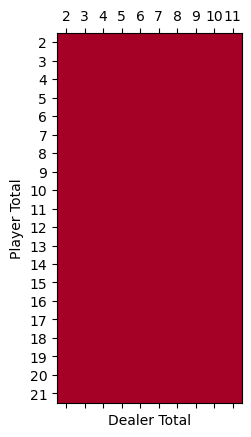

In [143]:
display_policy(agent)